In [24]:
import pandas as pd 
import geopy.distance
import os
import json
import pickle
import uuid
import warnings
from concurrent.futures import ThreadPoolExecutor
from datetime import datetime
import boto3
import numpy as np
import pandas as pd
from dateutil import relativedelta
from scipy.stats import randint as sp_randint
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals import joblib
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import holidays
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import xgboost

In [2]:
cd ..


/Users/nathantoubiana/Documents/Codes/Kaggle


In [3]:
cd all

/Users/nathantoubiana/Documents/Codes/Kaggle/all


In [4]:
df=pd.read_csv('train.csv')

In [5]:
def dist(lat1,long1,lat2,long2):
    try:
        coords_1 = (long1,lat1)
        coords_2 = (long2,lat2)

        return(geopy.distance.vincenty(coords_1, coords_2).km)
    except:
        return 'bug'

In [6]:
def lat_dist(lat1,long1,lat2,long2):
    return dist(lat1,long1,lat2,long1)

In [7]:
def long_dist(lat1,long1,lat2,long2):
    return dist(lat1,long1,lat1,long2)

In [8]:
df['distance']=df.apply(lambda x: dist(x.pickup_latitude,x.pickup_longitude,x.dropoff_latitude,x.dropoff_longitude),axis=1)

/Users/nathantoubiana/anaconda3/lib/python3.6/site-packages/geopy/point.py:81: UserWarning: Latitude normalization has been prohibited in the newer versions of geopy, because the normalized value happened to be on a different pole, which is probably not what was meant. If you pass coordinates as positional args, please make sure that the order is (latitude, longitude) or (y, x) in Cartesian terms.
  UserWarning)


In [9]:
df=df[df.distance!='bug']

In [10]:
df['latdistance']=df.apply(lambda x: lat_dist(x.pickup_latitude,x.pickup_longitude,x.dropoff_latitude,x.dropoff_longitude),axis=1)

In [11]:
df['longdistance']=df.apply(lambda x: long_dist(x.pickup_latitude,x.pickup_longitude,x.dropoff_latitude,x.dropoff_longitude),axis=1)

In [12]:
df=df[df.distance!='bug']

In [13]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,latdistance,longdistance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0.412061,0.280909,0.301449
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,4.64623,2.173992,4.104950
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,1.0048,0.329929,0.949115
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,0.914154,0.768510,0.495205
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,1.36616,0.485836,1.276794


In [200]:
y = df['fare_amount'].dropna(axis=0, how='any').as_matrix()

In [202]:
X.shape

(9999545, 6)

In [201]:
X = (df[[ 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count','distance']]
                 .dropna(axis=0, how='any')
                 .as_matrix())

In [203]:
clf = RandomForestRegressor(max_depth=15, max_features=5, n_estimators=100,n_jobs=-1)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=400)
clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [204]:
clf.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [205]:
df_test=pd.read_csv('test.csv')

In [206]:
def dist(lat1,long1,lat2,long2):
    try:
        coords_1 = (long1,lat1)
        coords_2 = (long2,lat2)

        return(geopy.distance.vincenty(coords_1, coords_2).km)
    except:
        return 'bug'

In [207]:
df_test['distance']=df_test.apply(lambda x: dist(x.pickup_latitude,x.pickup_longitude,x.dropoff_latitude,x.dropoff_longitude),axis=1)

In [208]:
X = (df_test[['pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count','distance']]
                 ._get_numeric_data()
                 .as_matrix())

In [209]:
predicted = clf.predict(X)



In [210]:
df_test['preds']=predicted

In [211]:
df_test_keys=df_test[['key','preds']]

In [212]:
df_final=pd.read_csv('sample_submission.csv')

In [213]:
df_final.fare_amount=df_final.merge(df_test_keys,on='key')['preds']

In [214]:
df_final[['key','fare_amount']].to_csv('results_nathan.csv' ,  index=False)

In [215]:
s = pickle.dumps(clf)
joblib.dump(clf, 'baseline_model.pkl')

['baseline_model.pkl']

MORE FEATURES

In [14]:
df.shape

(55421320, 11)

In [15]:
df['pickup_datetime'] = df['pickup_datetime'].str.slice(0, 16)
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')

In [16]:
def transform(data):
    # Extract date attributes and then drop the pickup_datetime column
    data['hour'] = data['pickup_datetime'].dt.hour
    data['day'] = data['pickup_datetime'].dt.day
    data['month'] = data['pickup_datetime'].dt.month
    data['year'] = data['pickup_datetime'].dt.year
    data['weekday']=data['pickup_datetime'].dt.weekday
    return data

In [17]:
df1=transform(df)

In [18]:
df1.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,latdistance,longdistance,hour,day,month,year,weekday
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:00,-73.844311,40.721319,-73.841610,40.712278,1,0.412061,0.280909,0.301449,17,15,6,2009,0
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:00,-74.016048,40.711303,-73.979268,40.782004,1,4.64623,2.173992,4.104950,16,5,1,2010,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,1.0048,0.329929,0.949115,0,18,8,2011,3
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:00,-73.987130,40.733143,-73.991567,40.758092,1,0.914154,0.768510,0.495205,4,21,4,2012,5
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,1.36616,0.485836,1.276794,7,9,3,2010,1


In [101]:
#df1.to_csv('train_with_features.csv')
dfcut=pd.read_csv('train_with_features.csv',nrows=3000000)

In [102]:
dfcut['pickup_datetime'] = dfcut['pickup_datetime'].str.slice(0, 16)
dfcut['pickup_datetime'] = pd.to_datetime(dfcut['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')

In [103]:
dfcut['pickup_datetime_2']=dfcut['pickup_datetime'].apply(lambda x: x.date())

In [104]:
cal = calendar()

holidays = cal.holidays(start=df['pickup_datetime'].min(), end=df['pickup_datetime'].max())



In [105]:
hol=[]
for i in holidays:
    hol.append(i.date())

In [106]:
dfcut['holiday'] = dfcut['pickup_datetime_2'].isin(hol)

In [107]:
dfcut.columns

Index(['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'distance', 'latdistance',
       'longdistance', 'hour', 'day', 'month', 'year', 'weekday',
       'pickup_datetime_2', 'holiday'],
      dtype='object')

In [108]:
y = dfcut['fare_amount'].dropna(axis=0, how='any').as_matrix()

In [109]:
X = (dfcut[[ 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count','distance','year','month','day','hour','weekday','distance','latdistance','longdistance','holiday']]
                 .dropna(axis=0, how='any')
                 .as_matrix())

In [110]:
X.shape

(3000000, 15)

In [111]:

#TO DO: 

#add holidays
#retrain with larger max depth
#add features about location zones (kmeans?)
#remove absurd outliers (water, etc)
#try radius NN
#try ANNOY?
#try ensembles of above models? add meta learning?


In [112]:
clf = xgboost.XGBRegressor(max_depth=20, max_features=5, n_estimators=100,n_jobs=-1)
#make max depth larger : 20

In [113]:
10*50/60

8.333333333333334

In [114]:
#>>>17 min

In [115]:
#4:30
#->1h
clf.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=20, max_features=5, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=-1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [116]:
df_test=pd.read_csv('test.csv')

In [117]:
df_test['distance']=df_test.apply(lambda x: dist(x.pickup_latitude,x.pickup_longitude,x.dropoff_latitude,x.dropoff_longitude),axis=1)

In [118]:
df_test['latdistance']=df_test.apply(lambda x: lat_dist(x.pickup_latitude,x.pickup_longitude,x.dropoff_latitude,x.dropoff_longitude),axis=1)

In [119]:
df_test['longdistance']=df_test.apply(lambda x: long_dist(x.pickup_latitude,x.pickup_longitude,x.dropoff_latitude,x.dropoff_longitude),axis=1)

In [120]:
df_test['pickup_datetime'] = df_test['pickup_datetime'].str.slice(0, 16)
df_test['pickup_datetime'] = pd.to_datetime(df_test['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')

In [121]:
df_test=transform(df_test)

In [122]:
df_test['pickup_datetime_2']=df_test['pickup_datetime'].apply(lambda x: x.date())

In [123]:
cal = calendar()

holidays = cal.holidays(start=df_test['pickup_datetime'].min(), end=df_test['pickup_datetime'].max())



In [124]:
df_test['holiday'] = df_test['pickup_datetime_2'].isin(hol)

In [125]:
X = (df_test[['pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count','distance','year','month','day','hour','weekday','distance','latdistance','longdistance','holiday']]
                 ._get_numeric_data()
                 .as_matrix())

In [126]:
X.shape

(9914, 15)

In [127]:
predicted = clf.predict(X)



In [128]:
df_test['preds']=predicted
df_test_keys=df_test[['key','preds']]
df_final=pd.read_csv('sample_submission.csv')
df_final.fare_amount=df_final.merge(df_test_keys,on='key')['preds']
df_final[['key','fare_amount']].to_csv('results_nathan.csv' ,  index=False)

In [129]:
s = pickle.dumps(clf)
joblib.dump(clf, 'xgb1.pkl')

['xgb1.pkl']

In [130]:
min(predicted)

2.6059942

(array([  3.20000000e+01,   1.23800000e+04,   1.89012000e+05,
          4.15221000e+05,   5.27213000e+05,   3.28231000e+05,
          3.59153000e+05,   2.31016000e+05,   1.99155000e+05,
          1.28258000e+05,   9.58140000e+04,   7.88900000e+04,
          6.88180000e+04,   4.62190000e+04,   4.02750000e+04,
          2.20630000e+04,   2.60120000e+04,   2.04620000e+04,
          1.98390000e+04,   1.65450000e+04,   1.53080000e+04,
          1.41750000e+04,   1.42450000e+04,   1.17820000e+04,
          9.71600000e+03,   9.22800000e+03,   6.93400000e+03,
          6.46600000e+03,   5.62000000e+03,   3.97400000e+03,
          3.81500000e+03,   2.63400000e+03,   1.05670000e+04,
          1.97900000e+03,   1.54200000e+03,   1.87530000e+04,
          1.82300000e+03,   6.93400000e+03,   9.30000000e+02,
          8.09000000e+02,   1.65390000e+04,   2.45500000e+03,
          8.86000000e+02,   5.17000000e+02,   4.75000000e+02,
          4.83000000e+02,   5.44000000e+02,   3.69000000e+02,
        

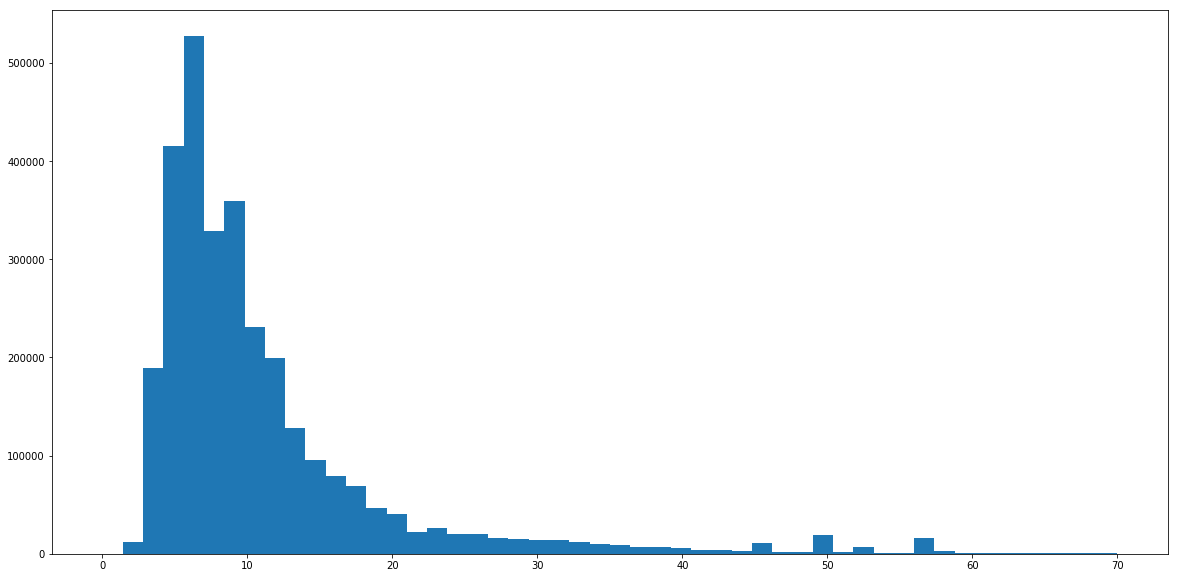

In [141]:
plt.figure(figsize=(20,10))
plt.hist(dfcut[(dfcut.fare_amount<70)&(dfcut.fare_amount>0)].fare_amount,bins=50)

In [133]:
import matplotlib.pyplot as plt
%matplotlib inline

In [135]:
dfcut.fare_amount.describe()

count    3.000000e+06
mean     1.134238e+01
std      9.828661e+00
min     -6.200000e+01
25%      6.000000e+00
50%      8.500000e+00
75%      1.250000e+01
max      1.273310e+03
Name: fare_amount, dtype: float64